# Time Series Analysis - 3 :  ARMA and ARIMA models

In this section, we're going to discuss two relatively complicated models - Auto Regressive Moving Average(ARMA) and Auto Regressive Integrated Moving Average(ARIMA) models.


In [1]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [13]:
import quandl
mydata=quandl.get("CUR/CNY", authtoken="iY9JSt_h18shZcXLXJ-y", start_date="2010-6-1")
mydata['logret']=np.log(1+mydata.RATE.pct_change(1))
mydata=mydata[1:]

In [3]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

### Autoregressive Moving Average Models - ARMA(p, q)

ARMA model is simply the merger between AR(p) and MA(q) models:

* AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets (market participant effects). 
* MA(q) models try to capture (explain) the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the observation process e.g. Surprise earnings, A terrorist attack, etc.

Hence, an ARMA model attempts to capture both of these aspects when modelling financial time series.Howveev, it does not take into account volatility clustering, a key empirical phenomena of many financial time series. 

$$x_t=\alpha_1x_{t-1}+…+\alpha_px_{t-p}+w_t+\beta_1w_{t-1}+…+\beta_qw_{t-q}$$ 

Where $w_t$ is white noise with $E(w_t)=0$ and variance $\sigma^2$

An ARMA model will often require fewer parameters than an AR(p) or MA(q) model alone. That is, it is redundant in its parameters

Let's simulate an ARMA(2, 2) process with given parameters, then fit an ARMA(2, 2) model and see if it can correctly estimate those parameters. Set alphas equal to [0.5,-0.25] and betas equal to [0.5,-0.3]. 

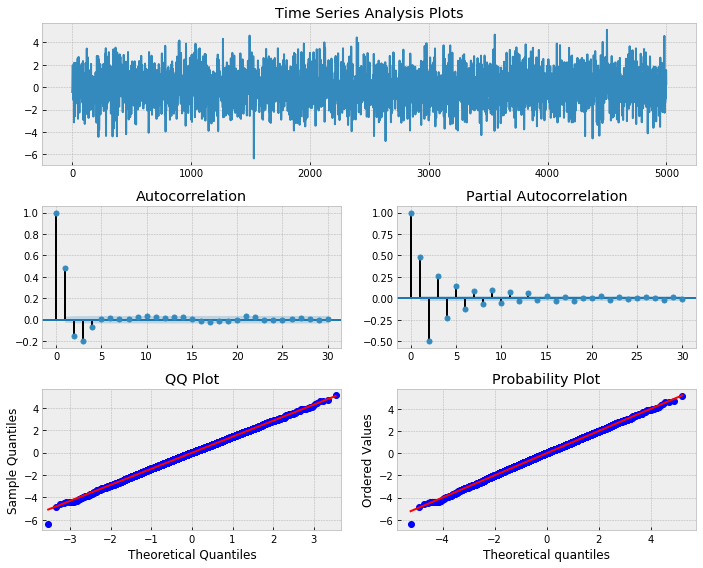

In [4]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)


In [5]:
mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7054.864
Method:                           mle   S.D. of innovations              0.992
Date:                Thu, 04 Oct 2018   AIC                          14119.727
Time:                        19:00:25   BIC                          14152.313
Sample:                             0   HQIC                         14131.148
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5230      0.057      9.201      0.000       0.412       0.634
ar.L2.y       -0.2552      0.015    -16.835      0.000      -0.285      -0.225
ma.L1.y        0.4732      0.058      8.122      0.0

**So how do we decide the values of $p$ and $q$ ?**

To fit data to an ARMA model, we use the [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) across a subset of values for p,q to find the model with minimum AIC and then apply the [Ljung-Box test](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test) to determine if a good fit has been achieved, for particular values of p,q. If the p value of the test is greater than the required significance, we can conclude that the residuals are independent and white noise.


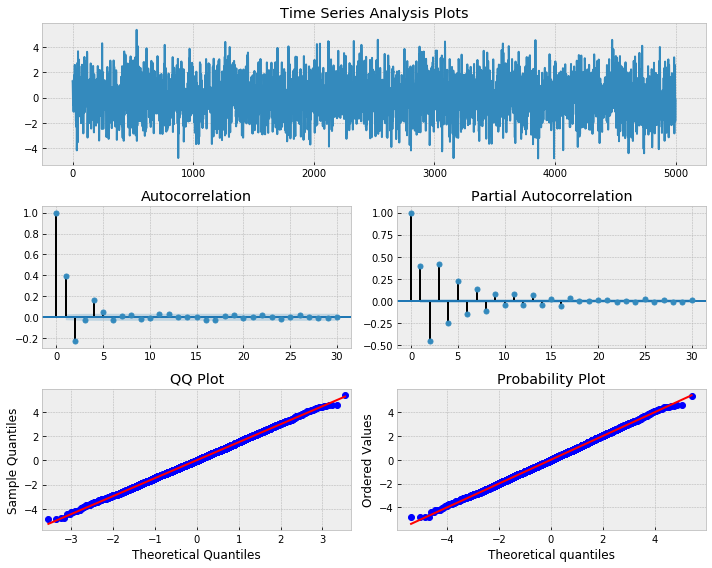

In [6]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.4,0.25] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.4, 0.25])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)


In [7]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(6)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: %6.5f | order: %s'%(best_aic, best_order))


aic: 14229.55822 | order: (3, 3)


In [8]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([18.09129235]), array([0.58139433]))

Notice that the p-value is greater than 0.05, which states that the residuals are independent at the 95% level and thus an ARMA(3,3) model provides a good model fit , which is not the case we expect !!! But what we are concern is the predictibility of our model. In other words, this model is wrong, but it is useful. 

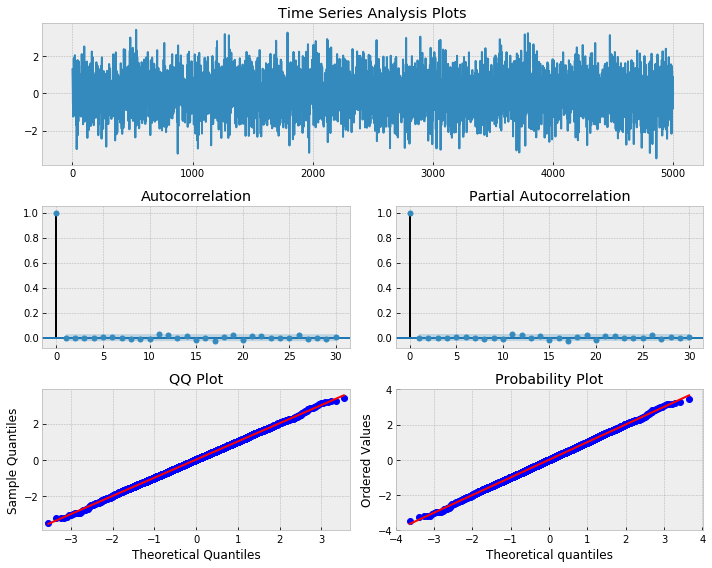

In [9]:
_ = tsplot(best_mdl.resid, lags=max_lag)

Also the model residuals look like white noise.

In [11]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print ('We have reason to suspect the residuals are not normally distributed.')
else:
    print ('The residuals seem normally distributed.')

The residuals seem normally distributed.


It's time for us to fit an ARMA model to CNY/USD log return.

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\ProgramData\Anacon

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

aic: -25742.96216 | order: (6, 5)


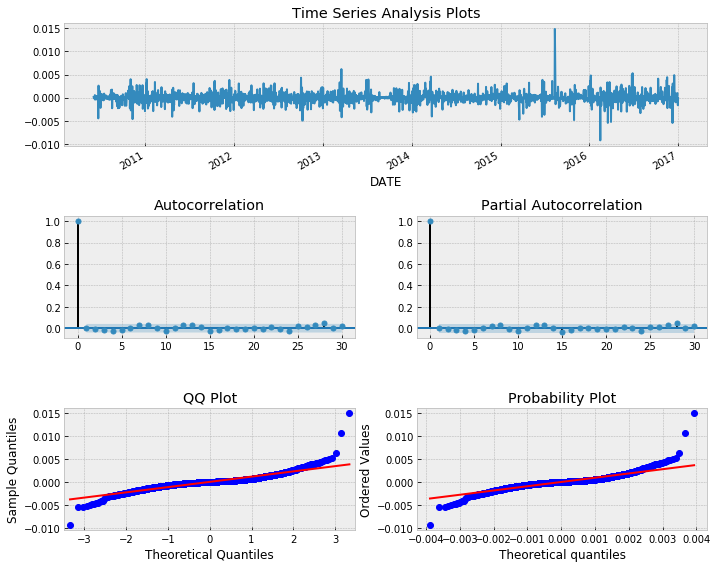

In [22]:
# Fit ARMA model to CNY/USD log returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(8) # [0,1,2,3,4,5,6,7]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(mydata.logret, order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

_ = tsplot(best_mdl.resid, lags=max_lag)

The best fitting model has ARMA(6,5). Both ACF and PACF look well in this case.

In [20]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)


(array([16.12480718]), array([0.70885184]))

Since p-value is much more that 0.05, we can conclude that this model is a good fit.

### Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

ARIMA is an extension to ARMA - they are used because they can reduce a non-stationary series to a stationary series using a sequence of differences. 

In a short sentence, just know that a time series $x_t$ is integrated of order $d$ if we difference the series $d$ times and receive a discrete white noise series.**

A time series $x_t$ is an autoregressive integrated moving average model of order p, d, q, ARIMA(p,d,q) if the series $x_t$ is differenced $d$ times, and it then follows an ARMA(p,q) process.

Let's simulate an ARIMA(2,1,1) model, with the $\alpha = [0.5, -0.25], \beta=-0.5$. Like before we will fit an ARIMA model to our simulated data, attempt to recover the parameters.

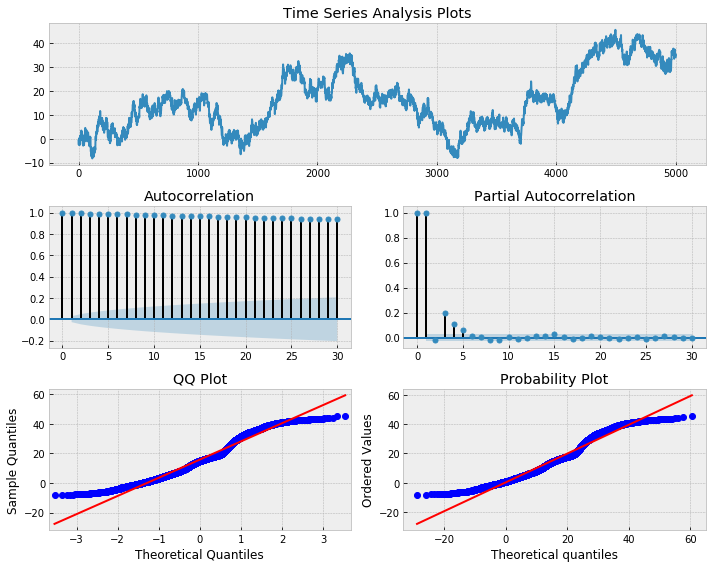

In [21]:
# Simulate an ARIMA(2,1,1) model with alphas=[0.5,-0.25] and betas=[-0.5]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5,-0.25])
betas = np.array([-0.5])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma11 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
arima111 = arma11.cumsum()
_ = tsplot(arima111, lags=max_lag)

aic: 14299.03083 | order: (2, 1, 3)


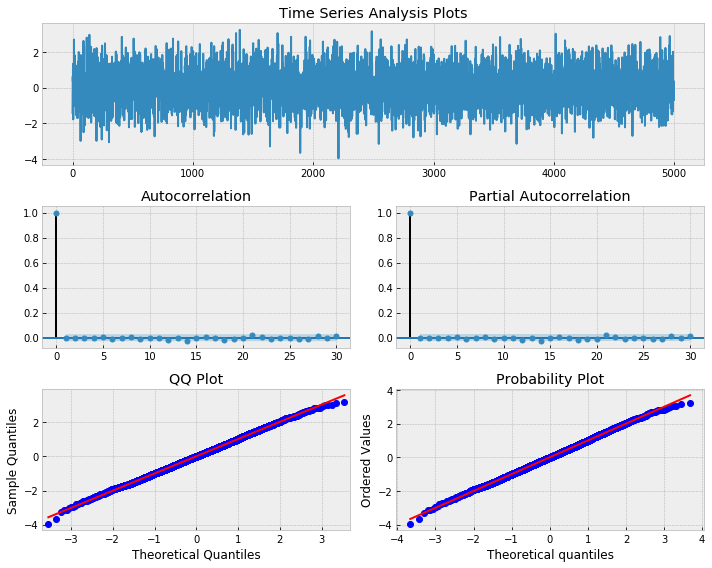

In [23]:
# Fit ARIMA(p, d, q) model
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(4) # [0,1,2,3]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(arima111, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: %6.5f | order: %s'%(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

Unlike the true model, we predict a ARIMA(2,1,3) model and the residuals looking like a realisation of discrete white noise:

In [24]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([8.51177164]), array([0.98790346]))

We perform the Ljung-Box test and find the p-value is significantly larger than 0.05 and as such we can state that there is strong evidence for discrete white noise being a good fit to the residuals. Hence, the ARIMA(2,1,3) model is a good fit. And our standard test for normality on residuals is below.

In [25]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print ('We have reason to suspect the residuals are not normally distributed.')
else:
    print ('The residuals seem normally distributed.')

The residuals seem normally distributed.


Next, let's use what we dicussed above to find the best ARIMA model to fit CNY/USD returns. Also, we use the AIC to evaluate each model. The lowest AIC wins. 

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

aic: -25742.96216 | order: (6, 0, 5)


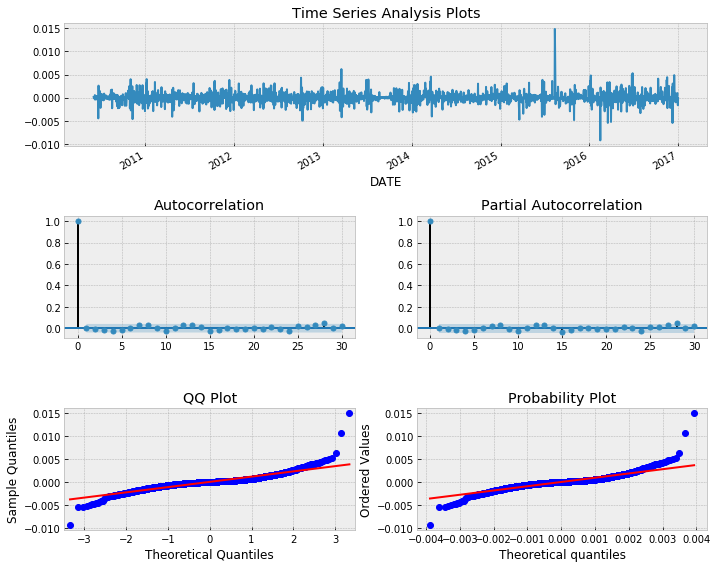

In [27]:
# Fit ARIMA(p, d, q) model to CNY/USD log returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(8) # [0,1,2,3,4,5,6,7]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(mydata.logret, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

No surprise that the best model has a differencing of 0! So the model is just the same as we fitted in the ARMA case.

In [28]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([16.12480718]), array([0.70885184]))

#### Forecasting

Now it's time to forecast the future returns by using the appropriate model. We use statmodels forecast() method - we need to provide the number of time steps to predict, and a decimal for the alpha argument to specify the confidence intervals. The default setting is 95% confidence. For 99% set alpha equal to 0.01. 

In [33]:
# Create a 7 day forecast of CNY/USD log returns with 95%, 99% CI
n_steps = 7

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx=range(1,8)
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
1,-0.000015,-0.002241,-0.002940,0.002211,0.002910
2,0.000263,-0.001965,-0.002665,0.002492,0.003192
3,0.000170,-0.002058,-0.002758,0.002399,0.003099
4,0.000131,-0.002098,-0.002799,0.002361,0.003061
5,0.000173,-0.002057,-0.002758,0.002402,0.003103
6,0.000188,-0.002043,-0.002743,0.002418,0.003119
7,0.000200,-0.002032,-0.002733,0.002432,0.003134
